In [2]:
import torch
from torch import nn
import math
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import torchdiffeq
from torchdiffeq import odeint
from act import sin,WA
from DNN import DNN
from NeuralODE import ODEFunc, ODEBlock, ODE_DNN

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Task 1

## Basical concept
Here is the programme of DAE task1,witch is denoted as:
$$
\left\{\begin{array}{c}
    \ddot{x} + \dot{y} = 2(sin^2\theta - cos^2\theta) + 2sin\theta cos\theta \\
    x + y = 1
\end{array}\right.
$$
 
We choose the activation function as follows:
$$
    \mathbf{\beta} Logsigmoid(h_{t-1}) + (1-\beta)sin(h_{t-1})
    \label{eq-act1}
$$

In [5]:
class DAE(nn.Module):
    def __init__(self):
        super(DAE,self).__init__()
        self.model = ODE_DNN(
            input_size=1,
            hidden_size=15,
            output_size=2,
            depth=10,
            num_ode_blocks=2,
            act = WA
        ).to(device)

        # Step size for t
        self.h = 0.01
        # Range of t
        t = torch.arange(0,2*math.pi+self.h,self.h)
        self.t_inside = t.reshape(630,1)

        # Boundary values of t
        self.t_bc = torch.zeros(630,1)  # t = 0
        self.t_bc1 = torch.full((630, 1), 2 * math.pi)

        # Values at the boundary
        x_bc = torch.ones(len(t))
        y_bc = torch.zeros(len(t))
        self.XY_bc = torch.cat([x_bc,y_bc]).reshape(2,-1).T

        # Move data to GPU
        self.t_bc = self.t_bc.to(device)
        self.t_bc1 = self.t_bc1.to(device)
        self.t_inside = self.t_inside.to(device)
        self.XY_bc = self.XY_bc.to(device)
        self.t_inside.requires_grad=True

        # Define loss function
        self.criterion = nn.MSELoss()

        # Define optimizer
        self.optim = torch.optim.Adam(self.model.parameters(),lr = 0.001)

        # Initialize iteration counter
        self.iter = 1

    # Loss function implementation
    # The loss consists of three parts: algebraic constraint violation, boundary condition violation, and differential equation violation
    # Idea: Take derivative of algebraic constraint (index=2) once
    def loss(self):
        # Clear gradients
        self.optim.zero_grad()
        # Part 1: boundary condition violation loss
        XY_pred_bc = self.model(self.t_bc)  # predictions at boundary t=0
        XY_pred_bc1 = self.model(self.t_bc1)  # predictions at boundary t=2π
        loss_bc = self.criterion(XY_pred_bc,self.XY_bc)
        loss_bc1 = self.criterion(XY_pred_bc1,self.XY_bc)

        # Compute derivatives
        XY_inside = self.model(self.t_inside)
        dX_dt = torch.autograd.grad(
            outputs=XY_inside[:,0],
            inputs=self.t_inside,
            grad_outputs=torch.ones_like(XY_inside[:,0]),
            create_graph=True
        )[0]
        dY_dt = torch.autograd.grad(
            outputs=XY_inside[:,1],
            inputs=self.t_inside,
            grad_outputs=torch.ones_like(XY_inside[:,1]),
            create_graph=True
        )[0]
        dX_dtt = torch.autograd.grad(
            outputs=dX_dt,
            inputs=self.t_inside,
            grad_outputs=torch.ones_like(dX_dt),
            create_graph=True
        )[0]

        # Part 2: algebraic constraint violation loss
        XY_pred = self.model(self.t_inside)
        x_pred = XY_pred[:, 0]
        y_pred = XY_pred[:, 1]
        alge = (x_pred + y_pred) - 1
        alge_d1 = dX_dt + dY_dt
        loss_alge = self.criterion(alge,torch.zeros_like(alge))
        loss_alge_d1 = self.criterion(alge_d1,torch.zeros_like(alge_d1))

        # Part 3: differential equation violation loss
        partial = dX_dtt + dY_dt - 2*(torch.sin(self.t_inside)**2 - torch.cos(self.t_inside)**2) - 2* torch.sin(self.t_inside)*torch.cos(self.t_inside)
        loss_partial = self.criterion(partial,torch.zeros_like(partial))

        loss = loss_bc + loss_partial  + loss_alge +loss_bc1

        return loss

    def train(self,epoches):
        self.model.train()
        for e in range(epoches):
            loss = self.loss()
            loss.backward()
            self.optim.step()
            self.optim.zero_grad()
            if e % 100 == 0:
                print(f'Epoch {e + 1}, Loss: {loss.item()}')

    def plot_results(self):
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(self.t_inside)
            t = self.t_inside.cpu().numpy()
            x_pred = predictions[:, 0].cpu().numpy()
            y_pred = predictions[:, 1].cpu().numpy()
            x_real = np.cos(t)**2
            y_real = np.sin(t)**2

            plt.figure(figsize=(10, 5))
            # Plot x_real and y_real using solid lines
            plt.plot(t, x_real, label="x_real(t)", linestyle="-")  # solid line
            plt.plot(t, y_real, label="y_real(t)", linestyle="-")  # solid line

            # Plot x_pred and y_pred using dashed lines
            plt.plot(t, x_pred, label="x_pred(t)", linestyle="--")  # dashed line
            plt.plot(t, y_pred, label="y_pred(t)", linestyle="--")  # dashed line

            plt.xlabel('t')
            plt.ylabel('Values')
            plt.legend()
            plt.title("Predictions vs Real Values vs t")
            plt.show()

    def calculate_mse(self):
        self.model.eval()
        self.model.load_state_dict(torch.load('model_full.pth'))
        with torch.no_grad():
            x_pred = self.model(self.t_inside)[:, 0].to(device)
            y_pred = self.model(self.t_inside)[:, 1].to(device)
            x_real = torch.cos(self.t_inside)**2
            y_real = torch.sin(self.t_inside)**2
            x_real = x_real.to(device)
            y_real = y_real.to(device)

            mse_x = self.criterion(x_pred, x_real)
            mse_y = self.criterion(y_pred, y_real)

            print(f'MSE for x: {mse_x.item()}')
            print(f'MSE for y: {mse_y.item()}')

    def save_model(self, save_path="30_30odemodel.pth", save_full_model=False):
        """
        Save the model.
        :param save_path: path to save the model
        :param save_full_model: whether to save the full model (architecture + parameters)
        """
        if save_full_model:
            # Save full model
            torch.save(self.model, save_path)
            print(f"Model saved to {save_path} (full model saved)")
        else:
            # Save only parameters (state_dict)
            torch.save(self.model.state_dict(), save_path)
            print(f"Model saved to {save_path} (only parameters saved)")


Epoch 1, Loss: 8.278450012207031
Epoch 101, Loss: 2.504110813140869
Epoch 201, Loss: 2.503868579864502
Epoch 301, Loss: 2.5035948753356934
Epoch 401, Loss: 0.5527640581130981
Epoch 501, Loss: 0.06573845446109772
Epoch 601, Loss: 0.0047415392473340034
Epoch 701, Loss: 0.0016406690701842308
Epoch 801, Loss: 0.0009893515380099416
Epoch 901, Loss: 0.0008707643137313426
Epoch 1001, Loss: 0.0006808773032389581
Epoch 1101, Loss: 0.0013651513727381825
Epoch 1201, Loss: 0.0005453755147755146
Epoch 1301, Loss: 0.010855374857783318
Epoch 1401, Loss: 0.00045281206257641315
Epoch 1501, Loss: 0.0004119334334973246
Epoch 1601, Loss: 0.00038629278424195945
Epoch 1701, Loss: 0.00035107170697301626
Epoch 1801, Loss: 0.00046242206008173525
Epoch 1901, Loss: 0.00030446768505498767
Epoch 2001, Loss: 0.00028075589216314256
Epoch 2101, Loss: 0.00026862116646952927
Epoch 2201, Loss: 0.0002463622367940843
Epoch 2301, Loss: 0.0019050065893679857
Epoch 2401, Loss: 0.00021915484103374183
Epoch 2501, Loss: 0.00020

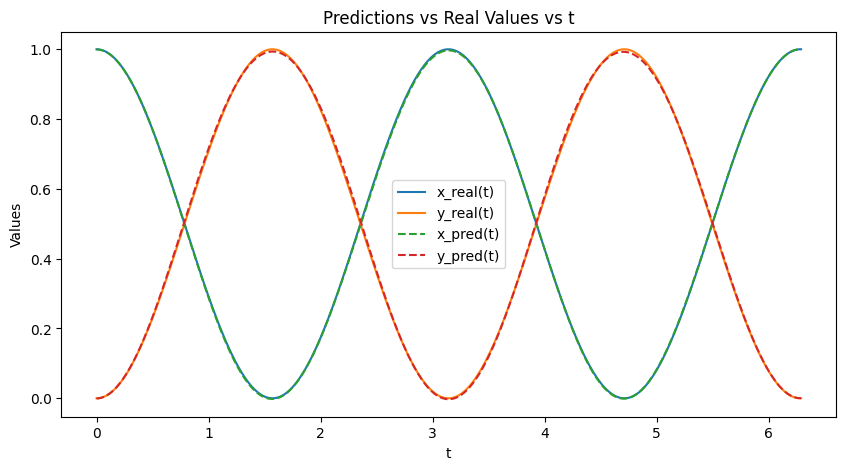

Model saved to 30_30odemodel.pth (only parameters saved)


In [6]:
DAE = DAE()
DAE.train(3001)
DAE.plot_results()
DAE.save_model()

## Explore 
You can explore the gradient flow via the outputs of each neuros.

In [9]:
import os

def visualize_model_activations(model_path="model_full.pth", input_tensor=None, save_path="activations"):
    """
    Visualize neuron activations of a saved model.
    
    :param model_path: Path to the saved model file
    :param input_tensor: Input tensor to feed into the model (default: t ∈ [0, 2π])
    """
    # Load the model
    model = ODE_DNN(input_size=1,
            hidden_size=15,
            output_size=2,
            depth=10,
            act = nn.Tanh).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Generate default input if none is provided
    if input_tensor is None:
        t = torch.arange(0, 2 * math.pi, 0.01).reshape(-1, 1).to(device)
        input_tensor = t

    activations = {}

    # Hook function to record activations
    def hook_fn(module, input, output):
        activations[module] = output.detach().cpu().numpy()

    # Register forward hooks
    hooks = []
    for layer in model.layers:
        hooks.append(layer.register_forward_hook(hook_fn))

    # Forward pass
    with torch.no_grad():
        _ = model(input_tensor)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Create directory if not exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Determine the number of rows and columns for subplots
    num_layers = len(activations)
    num_cols = 2  # 2 subplots per row
    num_rows = (num_layers + num_cols - 1) // num_cols

    # Create the overall figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten subplot array

    # Plot activations for each layer
    for i, (layer, activation) in enumerate(activations.items()):
        ax = axes[i]
        ax.plot(activation)
        ax.set_title(f'Activation of {layer}')
        ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper right', ncol=1)
        ax.grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()

    # Save figure as PNG file
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to free memory

    print(f"All activation plots have been saved to the '{save_path}' directory.")
# visualize_model_activations(model_path="30_30odemodel.pth.pth")

## Further Explore

You can verify the effectiveness of our designed activation function by comparing it with different functions.

In [19]:
def plot_predictions(weight_files, t_inside, save_path=None):
    """
    Plot predicted vs. true values using multiple weight files.

    :param weight_files: A list of four weight file paths
    :param t_inside: Input tensor
    :param save_path: Path to save the resulting figure (optional)
    """
    plt.figure(figsize=(20, 5))
    act = [WA, nn.ELU, nn.Tanh, nn.ReLU]

    # Create a dictionary mapping activation functions to their string names
    act_to_str = {
        WA: "Weight Activation",
        nn.ELU: "ELU",
        nn.Tanh: "Tanh",
        nn.ReLU: "ReLU"
    }

    for i, (weight_file, a) in enumerate(zip(weight_files, act)):
        # Create model instance
        model = ODE_DNN(input_size=1, hidden_size=15, output_size=2, depth=10, act=a).to(device)
        model.load_state_dict(torch.load(weight_file, map_location=device))
        model.eval()

        with torch.no_grad():
            predictions = model(t_inside)
            t = t_inside.cpu().numpy()
            x_pred = predictions[:, 0].cpu().numpy()
            y_pred = predictions[:, 1].cpu().numpy()
            x_real = np.cos(t)**2
            y_real = np.sin(t)**2

        # Create subplot
        ax = plt.subplot(1, 4, i + 1)

        # Plot x_real and y_real using solid lines
        ax.plot(t, x_real, label="x_real(t)", linestyle="-")  # solid line
        ax.plot(t, y_real, label="y_real(t)", linestyle="-")  # solid line

        # Plot x_pred and y_pred using dashed lines
        ax.plot(t, x_pred, label="x_pred(t)", linestyle="--")  # dashed line
        ax.plot(t, y_pred, label="y_pred(t)", linestyle="--")  # dashed line

        ax.set_xlabel('t')
        ax.set_ylabel('Values')

        # Use dictionary to get activation function name
        act_name = act_to_str.get(a, str(a))
        ax.set_title(f"(Act: {act_name})")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Figure saved to {save_path}")

    plt.show()


Figure saved to multiple_results.png


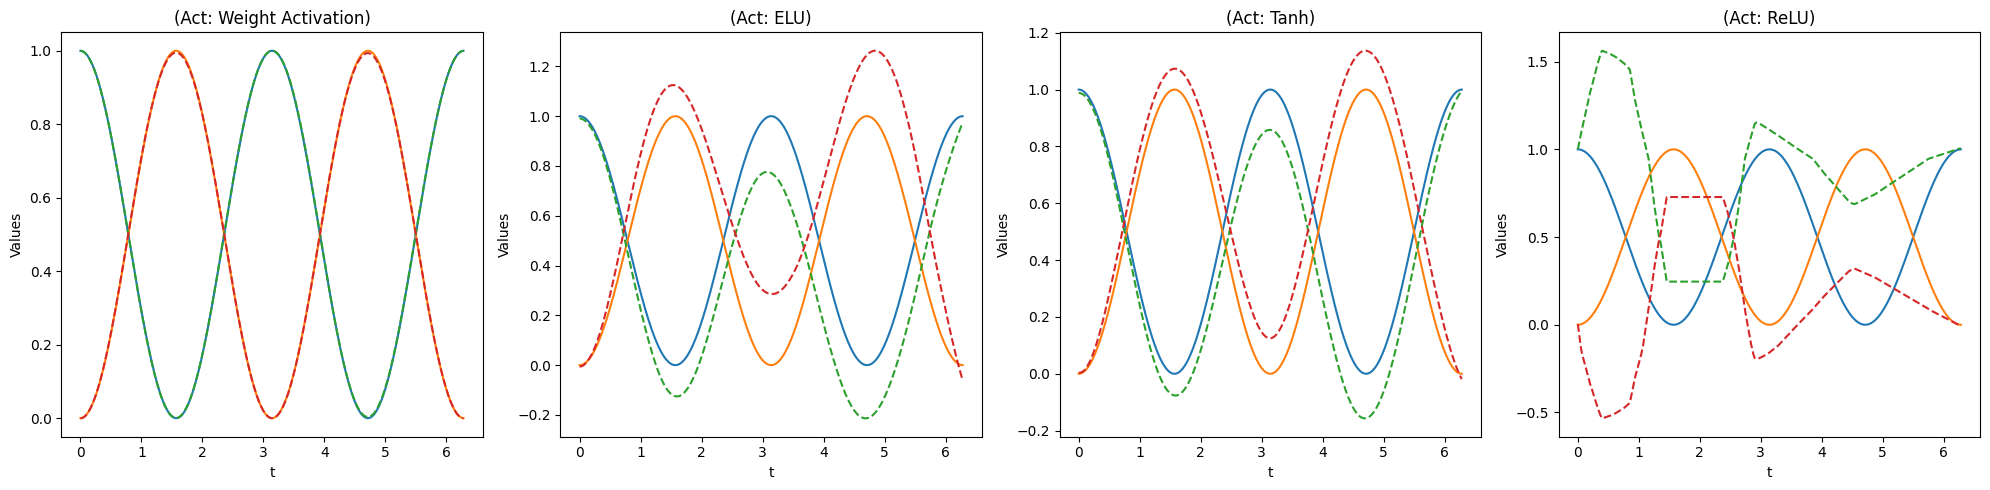

In [21]:
weight_files = ["ODEmodel.pth", "elumodel.pth", "tanhmodel.pth", "relumodel.pth"]
t_inside = torch.arange(0, 2 * np.pi, 0.01).reshape(-1, 1).to(device)
plot_predictions(weight_files, t_inside, save_path="multiple_results.png")